#PRACTICA NO SUPERVISADO: Ejercicio 1

## Importación de librerias necesarias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, KMeans, Birch
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist

## Carga de datos

In [ ]:
df = pd.read_csv('/content/sample_data/Tourists_data.csv')

## Tarea 1: Análisis descriptivo del dataset

### Preprocesamiento

In [ ]:
df = df.drop(columns=['A0', 'A0_1', 'A0_7', 'factoregatur'])
df =  df.dropna()

### Descripción e información de las variables

In [ ]:
print("Descripción: ")
print(df.describe())
print("Información: ")
df.info()

Descripción: 
             mm_aaaa             A1           pais           ccaa  \
count  621218.000000  621218.000000  621218.000000  621218.000000   
mean    68443.204416       1.962424       6.876805       7.381596   
std     32428.697952       0.480803       4.305359       4.038506   
min     12016.000000       1.000000       1.000000       1.000000   
25%     42018.000000       2.000000       3.000000       4.000000   
50%     72018.000000       2.000000       7.000000       9.000000   
75%     92021.000000       2.000000      11.000000      10.000000   
max    122022.000000       4.000000      15.000000      19.000000   

                 A13         aloja         motivo            A16  \
count  621218.000000  621218.00000  621218.000000  621218.000000   
mean        9.623696       1.80587       1.473481       5.103149   
std        12.689070       0.92985       0.795677       1.918312   
min         1.000000       1.00000       1.000000       1.000000   
25%         4.000000    

### Visualización de los datos

#### Histograma

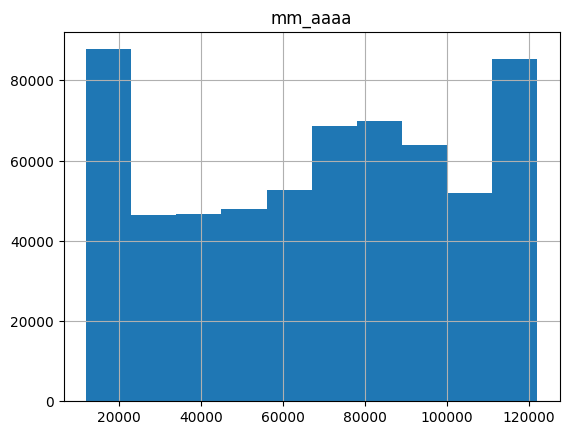

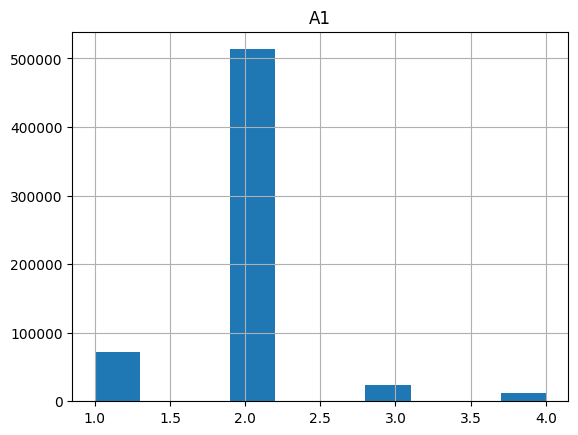

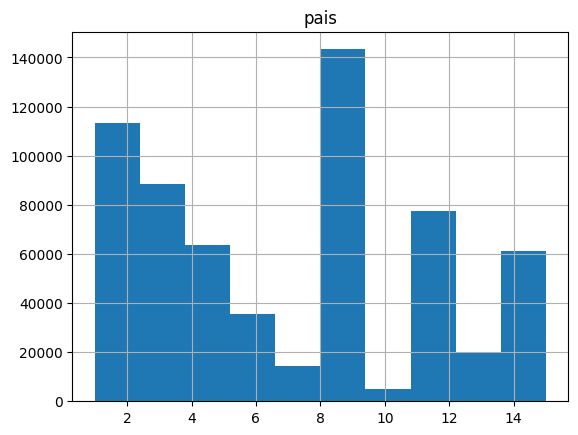

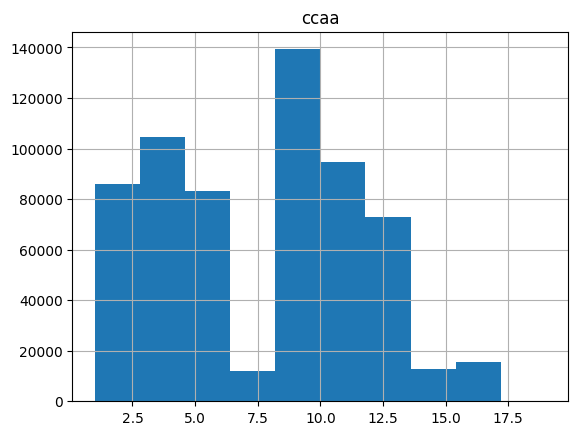

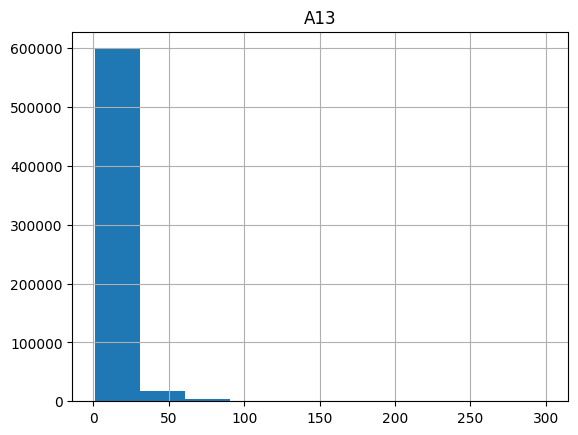

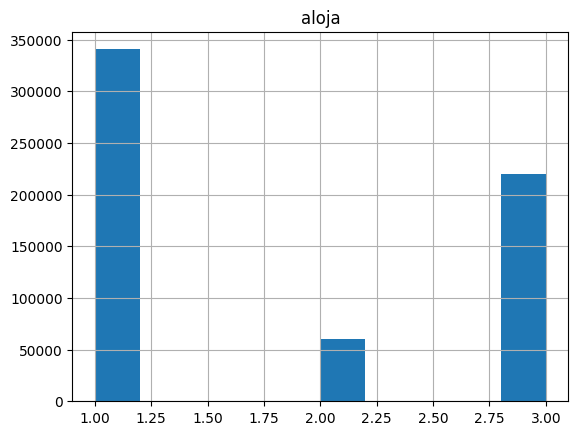

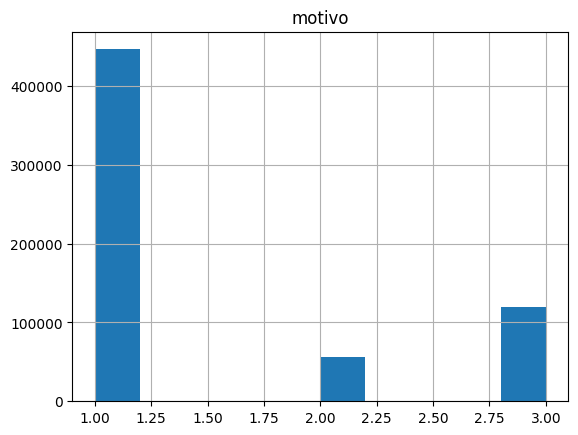

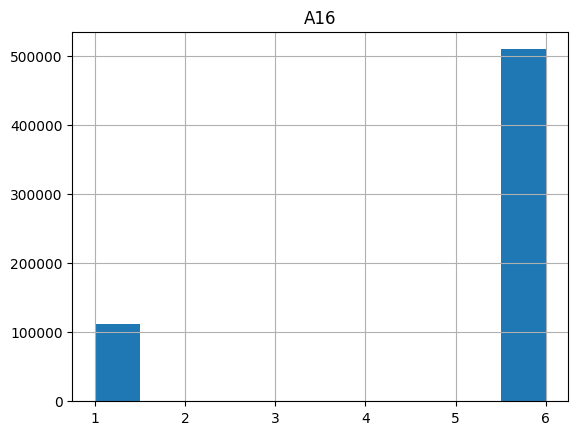

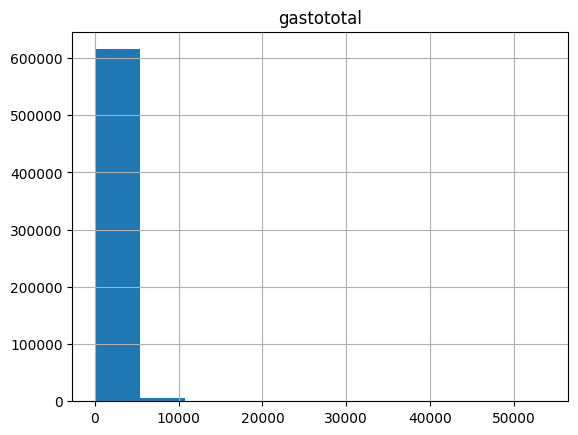

In [ ]:
for column in df.columns:
    plt.figure()
    df[column].hist()
    plt.title(column)

#### Diagrama de barras

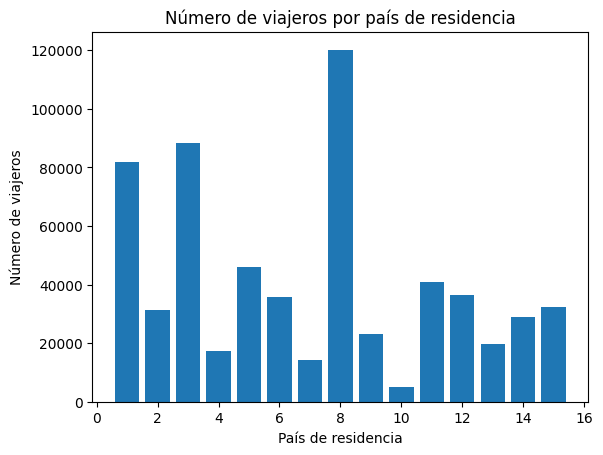

In [ ]:
counts = df['pais'].value_counts()
plt.bar(counts.index, counts.values)
plt.title('Número de viajeros por país de residencia')
plt.xlabel('País de residencia')
plt.ylabel('Número de viajeros')
plt.show()

#### Boxplot

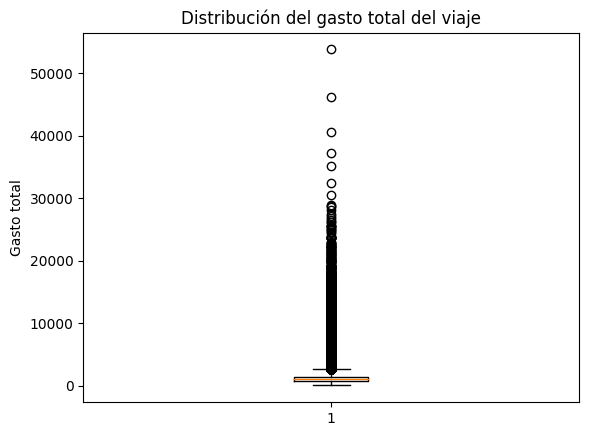

In [ ]:
plt.boxplot(df['gastototal'])
plt.title('Distribución del gasto total del viaje')
plt.ylabel('Gasto total')
plt.show()

#### Scatter plot

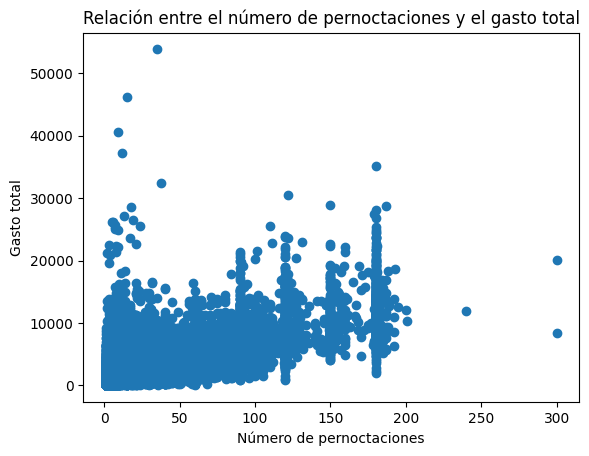

In [ ]:
plt.scatter(df['A13'], df['gastototal'])
plt.title('Relación entre el número de pernoctaciones y el gasto total')
plt.xlabel('Número de pernoctaciones')
plt.ylabel('Gasto total')
plt.show()

### Reducción de información del dataset


In [ ]:
sample_df = df.sample(frac=0.04, random_state=1)
print("Información: ")
sample_df.info()

Información: 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24849 entries, 607962 to 493913
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mm_aaaa     24849 non-null  int64  
 1   A1          24849 non-null  int64  
 2   pais        24849 non-null  int64  
 3   ccaa        24849 non-null  int64  
 4   A13         24849 non-null  int64  
 5   aloja       24849 non-null  int64  
 6   motivo      24849 non-null  int64  
 7   A16         24849 non-null  int64  
 8   gastototal  24849 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 1.9 MB


#### Histogramas
Hacemos los histogramas de nuevo para ver cómo quedó la información reducida

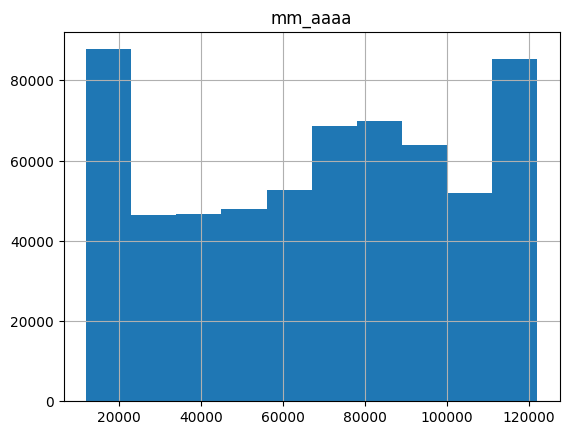

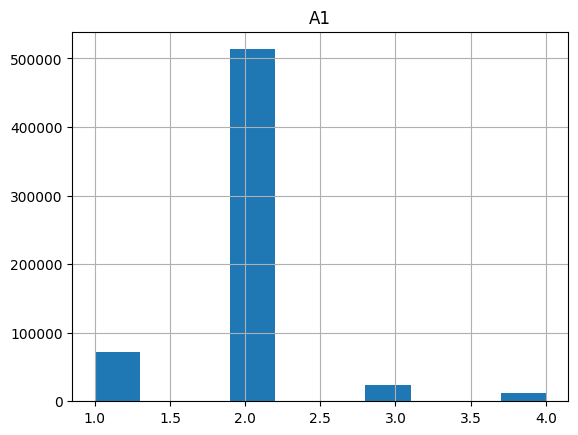

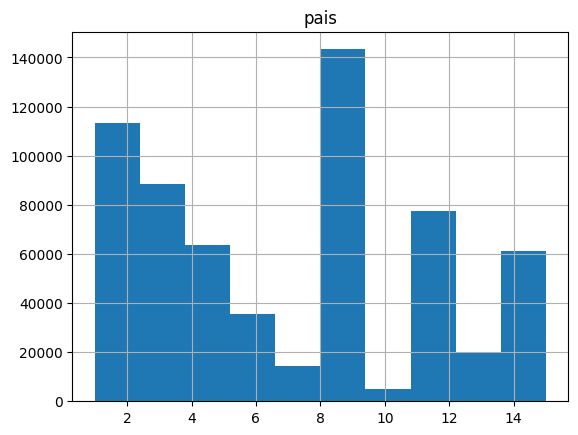

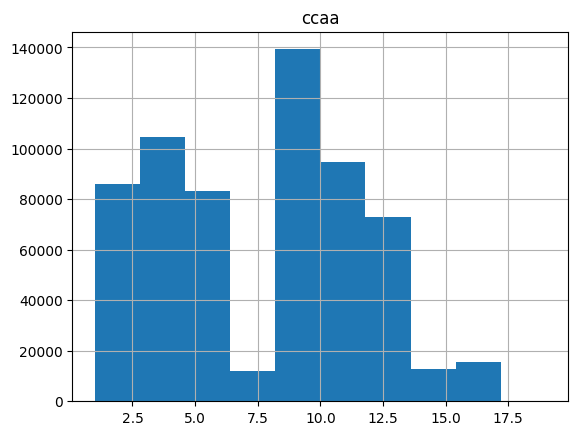

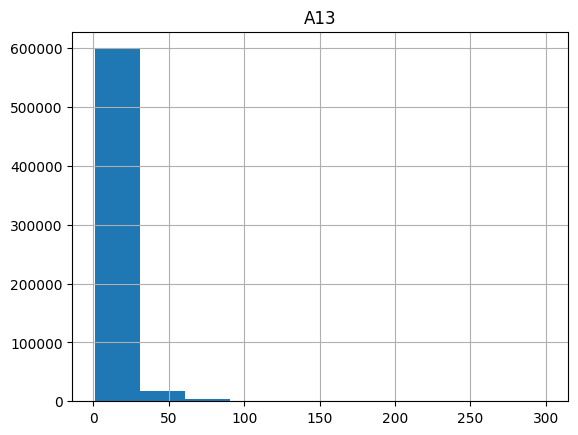

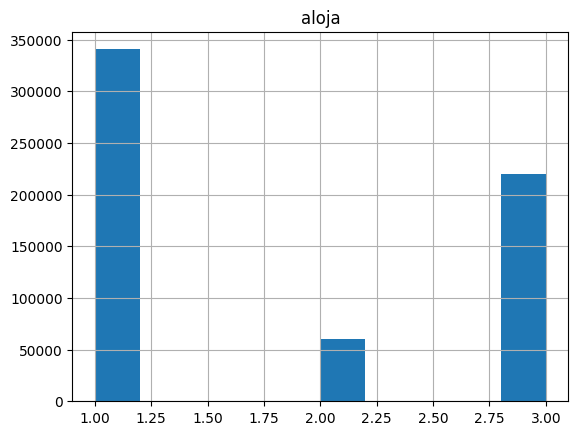

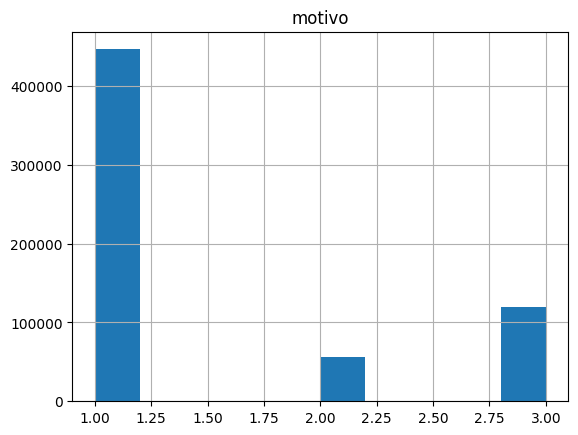

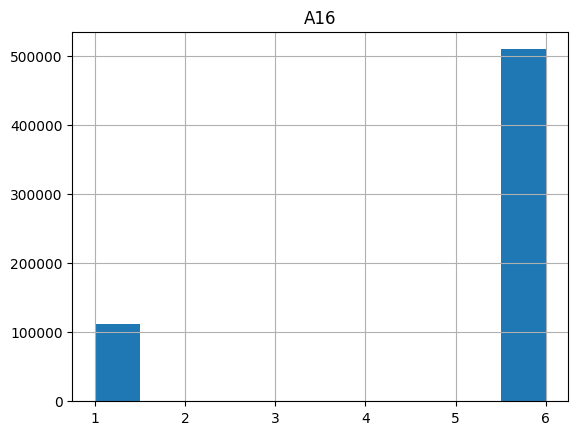

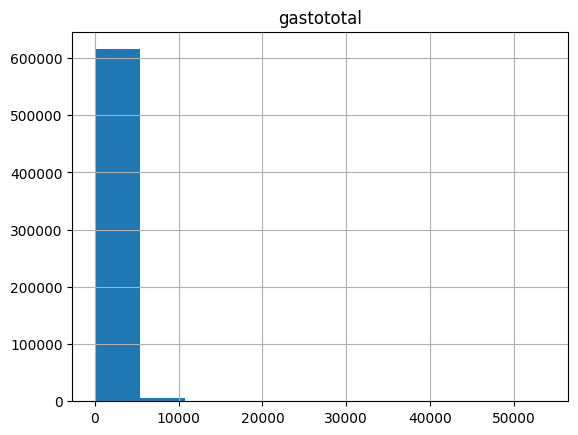

In [ ]:
for column in df.columns:
    plt.figure()
    df[column].hist()
    plt.title(column)

#### Scatter plot reducido
Aquí se verá el undersampling hecho viendo menos ruido entre clusters

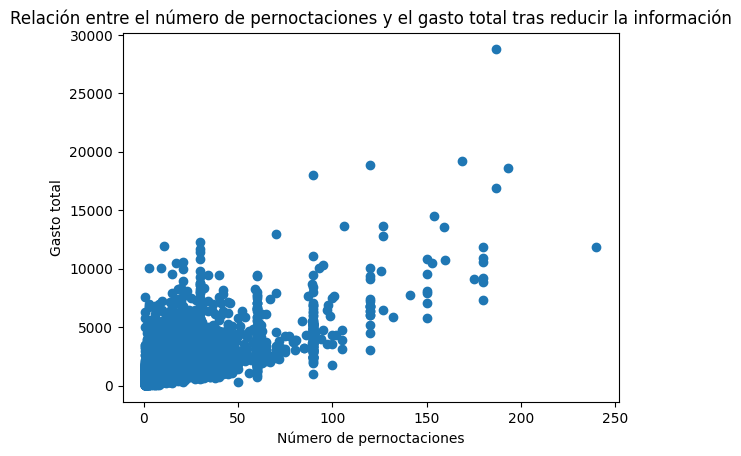

In [ ]:
plt.scatter(sample_df['A13'], sample_df['gastototal'])
plt.title('Relación entre el número de pernoctaciones y el gasto total tras reducir la información')
plt.xlabel('Número de pernoctaciones')
plt.ylabel('Gasto total')
plt.show()

## Matriz de similaridad

In [ ]:
X=sample_df.copy()
matriz_similaridad = pairwise_distances(X, metric='euclidean')
print("Matriz de similaridad:")
print("Matriz de similaridad:")
print(matriz_similaridad)

Matriz de similaridad:
Matriz de similaridad:
[[     0.          30002.48965641  40039.33897443 ...  50014.77714801
   20002.04544206  69997.41060742]
 [ 30002.48965641      0.          10175.53921256 ...  80014.30490737
   50003.01181789  99999.02393228]
 [ 40039.33897443  10175.53921256      0.         ...  90005.57009216
   60034.37750063 110017.19577844]
 ...
 [ 50014.77714801  80014.30490737  90005.57009216 ...      0.
   30031.63052636  20045.89604781]
 [ 20002.04544206  50003.01181789  60034.37750063 ...  30031.63052636
       0.          49996.01302147]
 [ 69997.41060742  99999.02393228 110017.19577844 ...  20045.89604781
   49996.01302147      0.        ]]


## 1.2 Algoritmos de clustering jerárquico
Correspondente con:
- **Tarea 2.1**: Aplica al menos 2 algoritmos de clustering jerárquico sobre el dataset proporcionado, probando y evaluando los efectos de la distancia utilizada (euclídea, coseno…)
-  **Tarea 2.2**:Analiza a determinadas profundidades la distribución de los ejemplos en el dendograma. ¿Es uniforme la distribución independientemente de la profundidad?
- **Tarea 2.3**:¿Cómo afectan las diferentes métricas de distancia a la estructura del dendrograma?

In [ ]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

No se escala el dataframe ya que en caso de hacerlo se pierde calidad del cluster

#### Algoritmo 1 : Linkage

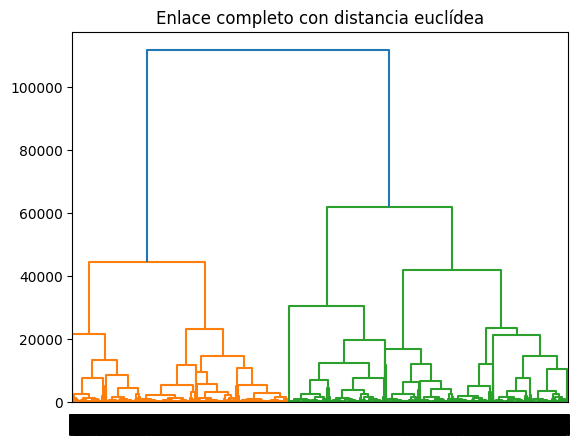

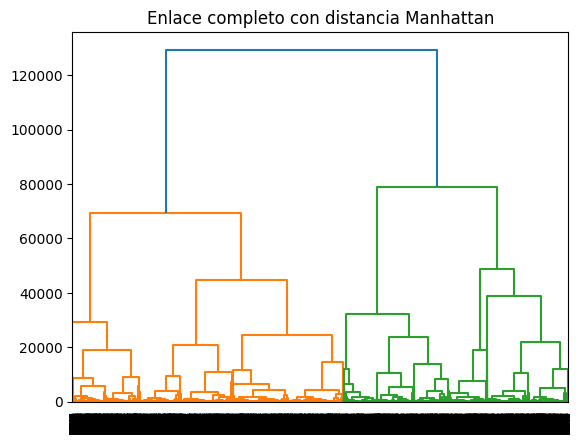

In [ ]:
#Enlace simple con distancia euclídea
X=sample_df.copy()
linked_euclidean_single = linkage(X, method='complete', metric='euclidean')
dendrogram(linked_euclidean_single)
plt.title('Enlace completo con distancia euclídea')
plt.show()

 # Enlace completo con distancia Manhattan
X=sample_df.copy()
linked_euclidean_complete = linkage(X, method='complete', metric='cityblock')
dendrogram(linked_euclidean_complete)
plt.title('Enlace completo con distancia Manhattan')
plt.show()




#### Algoritmo 2 : Agglomerative Clustering

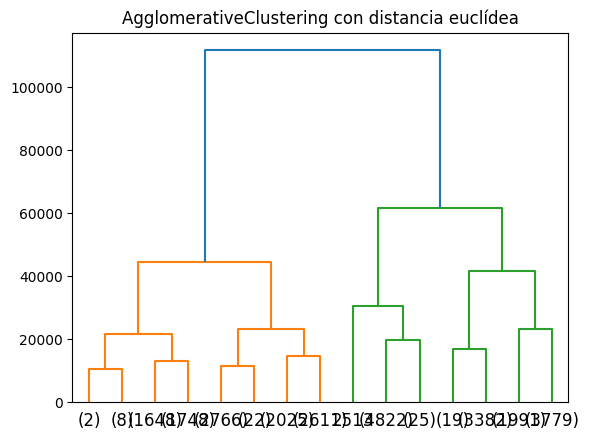

In [ ]:
#AgglomerativeClustering con distancia euclídea
X=sample_df.copy()
model = AgglomerativeClustering (n_clusters = None, linkage= 'complete', metric= 'euclidean' ,distance_threshold= 0.2)
model = model.fit(X)
plt.title('AgglomerativeClustering con distancia euclídea')
plot_dendrogram(model, truncate_mode="level", p=3)
plt.show()

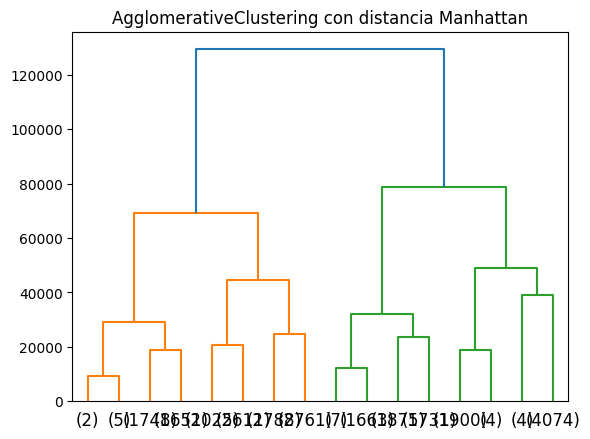

In [ ]:
#AgglomerativeClustering con distancia Manhattan
X=sample_df.copy()
model = AgglomerativeClustering (n_clusters = None, linkage= 'complete', metric= 'manhattan' ,distance_threshold= 0.2)
model = model.fit(X)
plt.title('AgglomerativeClustering con distancia Manhattan')
plot_dendrogram(model, truncate_mode="level", p=3)
plt.show()

## 1.3 Calidad del clustering
Corresponidente con:
- **Tarea 2.4**: Utiliza por lo menos dos índices de calidad de clustering y y analiza sus resultados.

In [ ]:
results1 = {}
algorithms = {
    'birch 0.2': Birch(n_clusters=3, threshold=0.2),
    'birch 0.3': Birch(n_clusters=3, threshold=0.3),
    'birch 0.4': Birch(n_clusters=3, threshold=0.4),
    'birch 0.5': Birch(n_clusters=3, threshold=0.5)
}

#### Silhouette Score

In [ ]:
def fit_and_evaluate_silhouette (algorithm, data, n_clusters):
  Z=data.copy()
  algorithm.fit(Z)
  labels = algorithm.predict(Z)
  score = silhouette_score(Z, labels)
  return score

In [ ]:
X=sample_df.copy()
for name , algorithm in algorithms.items():
  score = fit_and_evaluate_silhouette(algorithm, X , n_clusters=3);
  results1[name] = score

results_df_BIRCH =pd.DataFrame (list(results1.items()), columns = ['Algorithm', 'Silhouette Score'])
print(results_df_BIRCH)



   Algorithm  Silhouette Score
0  birch 0.2          0.598532
1  birch 0.3          0.598532
2  birch 0.4          0.598532
3  birch 0.5          0.598587


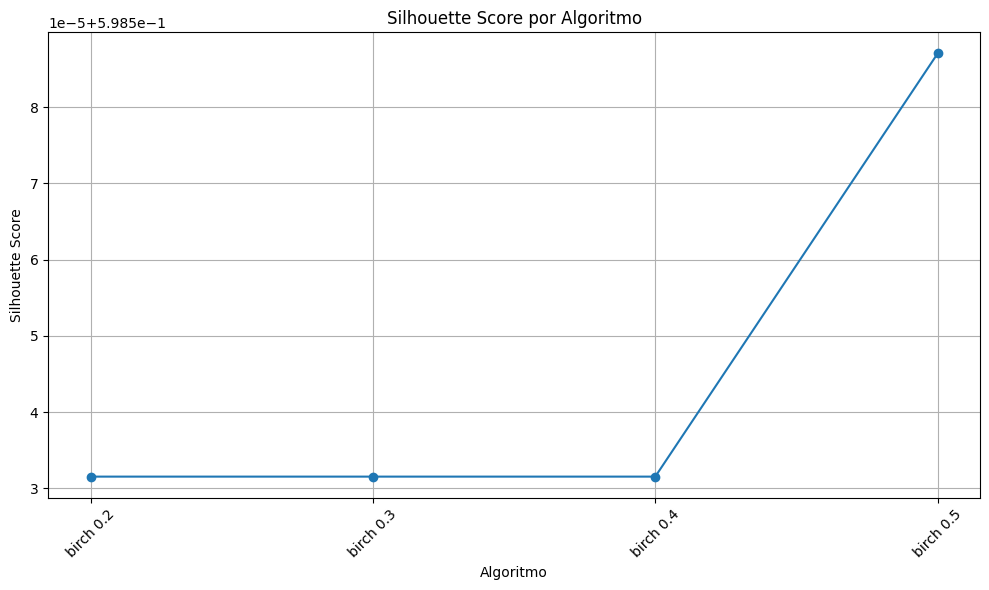

In [ ]:
algorithms = results_df_BIRCH['Algorithm']
scores = results_df_BIRCH['Silhouette Score']

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.plot(algorithms, scores, marker='o', linestyle='-')
plt.xlabel('Algoritmo')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Algoritmo')
plt.xticks(rotation=45)  # Rotar los nombres de los algoritmos para mayor legibilidad
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

#### Davies-Bouldin

In [ ]:
results2 = {}
algorithms = {
    'birch 0.2': Birch(n_clusters=3, threshold=0.2),
    'birch 0.3': Birch(n_clusters=3, threshold=0.3),
    'birch 0.4': Birch(n_clusters=3, threshold=0.4),
    'birch 0.5': Birch(n_clusters=3, threshold=0.5)
}

In [ ]:
def fit_and_evaluate_davies (algorithm, data, n_clusters):
  algorithm.fit(data)
  labels = algorithm.predict(data)
  score = davies_bouldin_score(data, labels)
  return score

In [ ]:
X=sample_df.copy()
for name , algorithm in algorithms.items():
  score = fit_and_evaluate_davies(algorithm, X , n_clusters=3);
  results2[name] = score

results_df_BIRCH =pd.DataFrame (list(results2.items()), columns = ['Algorithm', 'Davies-Bouldin Score'])
print(results_df_BIRCH)

   Algorithm  Davies-Bouldin Score
0  birch 0.2              0.524250
1  birch 0.3              0.524250
2  birch 0.4              0.524250
3  birch 0.5              0.524184


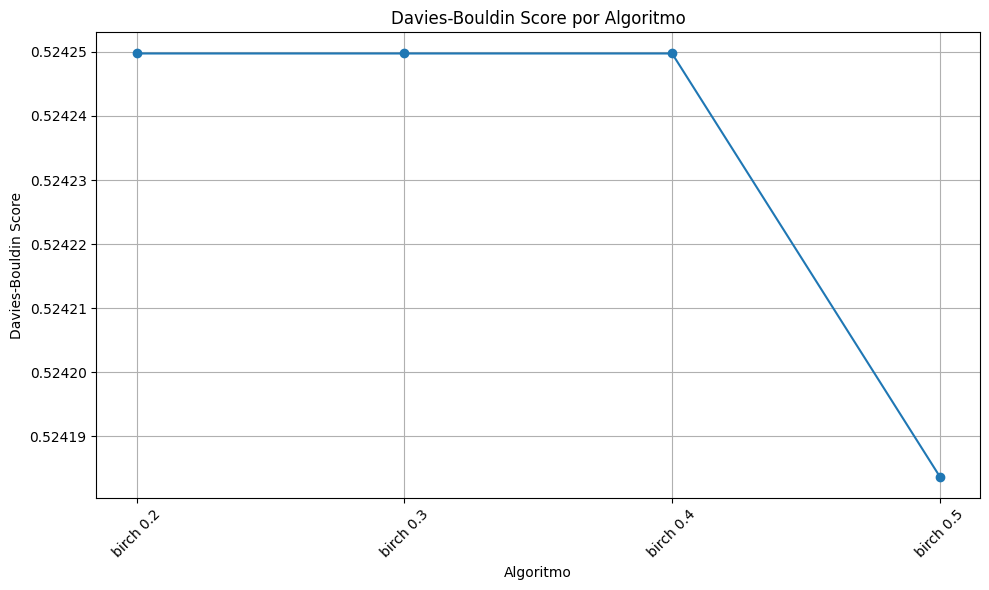

In [ ]:
algorithms = results_df_BIRCH['Algorithm']
scores = results_df_BIRCH['Davies-Bouldin Score']

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.plot(algorithms, scores, marker='o', linestyle='-')
plt.xlabel('Algoritmo')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score por Algoritmo')
plt.xticks(rotation=45)  # Rotar los nombres de los algoritmos para mayor legibilidad
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

### 1.4 Número de clusters
- **Tarea 2.5**: ¿Cuál es el número óptimo de clusters? ¿por qué?

In [ ]:
results2 = {}
algorithms = {
    'birch 2': Birch(n_clusters=2, threshold=0.5),
    'birch 3': Birch(n_clusters=3, threshold=0.5),
    'birch 4': Birch(n_clusters=4, threshold=0.5),
    'birch 5': Birch(n_clusters=5, threshold=0.5),
    'birch 6': Birch(n_clusters=6, threshold=0.5),
    'birch 7': Birch(n_clusters=7, threshold=0.5),
    'birch 8': Birch(n_clusters=8, threshold=0.5),
    'birch 9': Birch(n_clusters=9, threshold=0.5),
    'birch 10': Birch(n_clusters=10, threshold=0.5)
}

In [ ]:
X=sample_df.copy()
for name , algorithm in algorithms.items():
  score = fit_and_evaluate_silhouette(algorithm, X , n_clusters=3);
  results1[name] = score

results_df_BIRCH =pd.DataFrame (list(results1.items()), columns = ['Algorithm', 'Silhouette Score'])
print(results_df_BIRCH)

    Algorithm  Silhouette Score
0   birch 0.2          0.598532
1   birch 0.3          0.598532
2   birch 0.4          0.598532
3   birch 0.5          0.598587
4     birch 2          0.576359
5     birch 3          0.598587
6     birch 4          0.562113
7     birch 5          0.613815
8     birch 6          0.655830
9     birch 7          0.688042
10    birch 8          0.738977
11    birch 9          0.785939
12   birch 10          0.826034


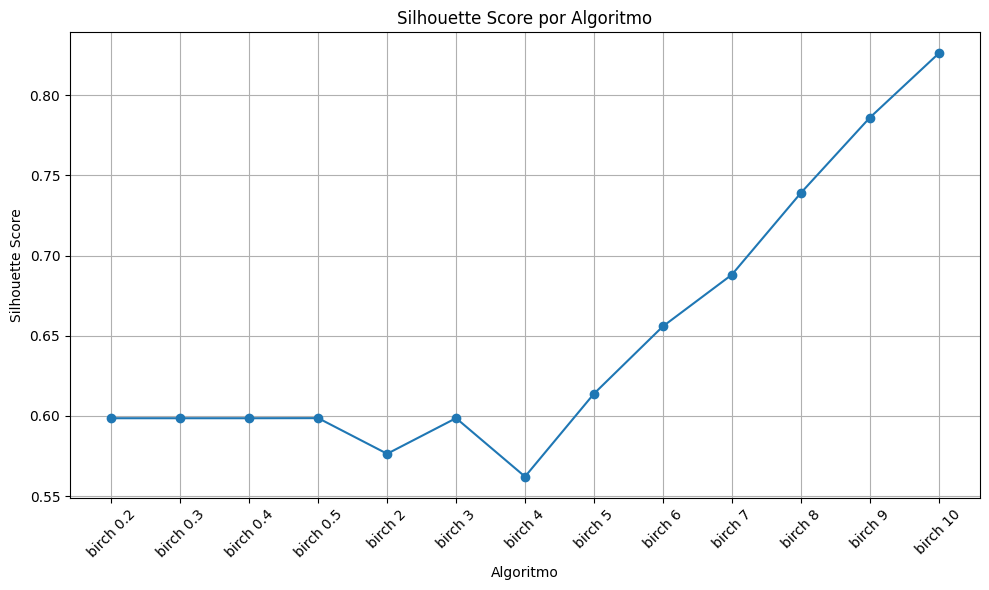

In [ ]:
algorithms = results_df_BIRCH['Algorithm']
scores = results_df_BIRCH['Silhouette Score']

# Crear la gráfica de barras
plt.figure(figsize=(10, 6))
plt.plot(algorithms, scores, marker='o', linestyle='-')
plt.xlabel('Algoritmo')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score por Algoritmo')
plt.xticks(rotation=45)  # Rotar los nombres de los algoritmos para mayor legibilidad
plt.grid(True)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

El **número óptimo de clusters** como se observa es **10** ya que es el que tiene mayor índice de Silhouette Score

### 1.5 Predicción
- **Tarea 2.6**: Identificar perfil gasto viajero

In [ ]:
caracteristicas = df[['aloja', 'A13', 'pais', 'ccaa']].sample(frac=0.2, random_state=1)

# Entrenar el modelo de KMeans
kmeans = KMeans(n_clusters=3,random_state=50)
modelo_clustering = kmeans.fit(caracteristicas)

# Supongamos que tienes un diccionario que mapea los clusters a perfiles de gasto
mapeo_cluster_perfil_gasto = {
    0: "Perfil bajo",
    1: "Perfil medio",
    2: "Perfil alto",
}

Z= caracteristicas.copy()
label=kmeans.predict(Z)
score=silhouette_score(Z, label)
print ("Silhoute Score: ")
print (score)

# Función para obtener el perfil de gasto del viajero
def obtener_perfil_gasto(tipo_alojamiento, num_noches, pais_residencia, ccaa_destino):
    datos = np.array([[tipo_alojamiento, num_noches, pais_residencia, ccaa_destino]])
    cluster_pred = modelo_clustering.predict(datos)
    perfil_gasto = mapeo_cluster_perfil_gasto[cluster_pred[0]]
    return perfil_gasto

# Ejemplo de uso de la función para obtener el perfil de gasto
perfil = obtener_perfil_gasto(tipo_alojamiento=2, num_noches=2, pais_residencia=14, ccaa_destino=2)
print("El perfil de gasto más probable es:", perfil)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Silhoute Score: 
0.606581621887852
El perfil de gasto más probable es: Perfil alto


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
